# PyTorch Pruning: _LeNet-5_ Conv Net

Trained on MNIST dataset using __layer-wise structured absolute magnitude__ based pruning.

[PyTorch Pruning Tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#serializing-a-pruned-model)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

Available device: cpu


In [4]:
# Hyper-parameters-
# input_size = 784    # 28 x 28, flattened to be 1-D tensor
# hidden_size = 100
num_classes = 10
num_epochs = 20
batch_size = 32
learning_rate = 0.0012

In [5]:
# MNIST dataset statistics:
# mean = tensor([0.1307]) & std dev = tensor([0.3081])
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [7]:
os.chdir("/home/arjun/Documents/Programs/Python_Codes/PyTorch_Resources/Good_Codes/")

In [8]:
# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = './data', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = './data', train = False,
        transform = transforms_apply
        )


print(f"len(train_dataset): {len(train_dataset)} & len(test_dataset): {len(test_dataset)}")

len(train_dataset): 60000 & len(test_dataset): 10000


In [9]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")
len(train_loader), len(test_loader)

len(train_loader) = 1875 & len(test_loader) = 313


(1875, 313)

### Create a model:

In this tutorial, we use the [LeNet CNN](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) architecture from LeCun et al., 1998.

In [10]:
class LeNet5(nn.Module):
    '''
    Implements a variation of LeNet-5 CNN. It is LeNet-4.
    '''
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6,
            kernel_size = 3, padding = 1,
            stride = 1
        )
        
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 3, padding = 1,
            stride = 1
        )
        
        self.conv3 = nn.Conv2d(
            in_channels = 16, out_channels = 120,
            kernel_size = 3, padding = 1,
            stride = 1
        )
        
        self.pool = nn.MaxPool2d(
            kernel_size = 2, stride = 2
        )
        
        self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(in_features = 512, out_features = 256)
        # self.fc2 = nn.Linear(in_features = 120, out_features = 84)
        # self.op = nn.Linear(in_features = 84, out_features = 10)
        self.op = nn.Linear(in_features = 1080, out_features = 10)
        
        self.weights_initialization()
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        return self.op(x)
    
    
    def shape_computation(self, x):
        x = self.conv1(x)
        print(f"conv1.shape = {x.shape}")
        
        x = self.pool(x)
        print(f"pool.shape = {x.shape}")
        
        x = self.conv2(x)
        print(f"conv2.shape = {x.shape}")
        
        x = self.pool(x)
        print(f"pool.shape = {x.shape}")
        
        x = self.conv3(x)
        print(f"conv3.shape = {x.shape}")
        
        x = self.pool(x)
        print(f"pool.shape = {x.shape}")
        
        x = self.flatten(x)
        print(f"flatten.shape = {x.shape}")
        
        x = self.op(x)
        print(f"output.shape = {x.shape}")
        
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

        

In [20]:
model = LeNet5().to(device = device)

In [21]:
# Define loss and optimizer-
loss = nn.CrossEntropyLoss()    # applies softmax for us
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [11]:
def count_params(model):
    
    tot_params = 0
    for layer_name, param in model.named_parameters():
        # print(f"{layer_name}.shape = {param.shape} has {torch.count_nonzero(param.data)} non-zero params")
        tot_params += torch.count_nonzero(param.data)
    
    return tot_params


In [ ]:
orig_params = count_params(model)
print(f"Unpruned LeNet-4 model has {orig_params} trainable parameters")

In [19]:
for layer, param in model.named_parameters():
    print(f"layer.name: {layer} & param.shape = {param.shape}")

layer.name: conv1.weight & param.shape = torch.Size([6, 1, 3, 3])
layer.name: conv1.bias & param.shape = torch.Size([6])
layer.name: conv2.weight & param.shape = torch.Size([16, 6, 3, 3])
layer.name: conv2.bias & param.shape = torch.Size([16])
layer.name: conv3.weight & param.shape = torch.Size([120, 16, 3, 3])
layer.name: conv3.bias & param.shape = torch.Size([120])
layer.name: op.weight & param.shape = torch.Size([10, 1080])
layer.name: op.bias & param.shape = torch.Size([10])


### Train model:

In [13]:
def train_model(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0

    for batch, (images, labels) in enumerate(train_loader):
        # Reshape image and place it on GPU-
        # images = images.reshape(-1, input_size).to(device)
        images = images.to(device)
        labels = labels.to(device) 
        outputs = model(images)   # forward pass
        J = loss(outputs, labels) # compute loss
        optimizer.zero_grad()     # empty accumulated gradients
        J.backward()              # perform backpropagation
        optimizer.step()          # update parameters

        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_steps}, loss = {J.item():.4f}")
        '''

    return running_loss, running_corrects


In [14]:
def test_model(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            # images = images.reshape(-1, input_size).to(device)
            images = images.to(device)
            labels = labels.to(device)
            # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    return (running_loss_val, correct, total)


In [22]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3


# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [23]:
# Python3 lists to store model training metrics-
training_acc = []
validation_acc = []
training_loss = []
validation_loss = []

In [24]:
# Training loop-
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break

    running_loss, running_corrects = train_model(model, train_loader)
  
    # Compute training loss and accuracy for one epoch-
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    # epoch_acc = 100 * running_corrects / len(trainset)
    # print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%\n")

    running_loss_val, correct, total = test_model(model, test_loader)

    # Compute validation loss and accuracy-
    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)
    # print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

    print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

    # Code for manual Early Stopping:
    # if np.abs(epoch_val_loss < best_val_loss) >= minimum_delta:
    if (epoch_val_loss < best_val_loss) and np.abs(epoch_val_loss - best_val_loss) >= minimum_delta:
        # print(f"epoch_val_loss = {epoch_val_loss:.4f}, best_val_loss = {best_val_loss:.4f}")
        
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = epoch_val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
        print(f"Saving model with lowest val_loss = {epoch_val_loss:.4f}\n")
        
        # Save trained model with validation accuracy-
        # torch.save(model.state_dict, f"LeNet-300-100_Trained_{val_acc}.pth")
        torch.save(model.state_dict(), "LeNet-4_Trained.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement


    training_acc.append(epoch_acc * 100)
    validation_acc.append(val_acc)
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)



epoch: 1 training loss = 0.1485, training accuracy = 95.45%, val_loss = 0.0536 & val_accuracy = 98.29%

Saving model with lowest val_loss = 0.0536


epoch: 2 training loss = 0.0486, training accuracy = 98.43%, val_loss = 0.0457 & val_accuracy = 98.51%

Saving model with lowest val_loss = 0.0457


epoch: 3 training loss = 0.0358, training accuracy = 98.87%, val_loss = 0.0422 & val_accuracy = 98.75%

Saving model with lowest val_loss = 0.0422


epoch: 4 training loss = 0.0278, training accuracy = 99.11%, val_loss = 0.0372 & val_accuracy = 98.86%

Saving model with lowest val_loss = 0.0372


epoch: 5 training loss = 0.0236, training accuracy = 99.23%, val_loss = 0.0304 & val_accuracy = 99.14%

Saving model with lowest val_loss = 0.0304


epoch: 6 training loss = 0.0186, training accuracy = 99.40%, val_loss = 0.0343 & val_accuracy = 99.06%


epoch: 7 training loss = 0.0162, training accuracy = 99.47%, val_loss = 0.0393 & val_accuracy = 98.90%


epoch: 8 training loss = 0.0137, training ac

In [42]:
# Initialize and load best weights-
best_model = LeNet5().to(device = device)
best_model.load_state_dict(torch.load("/home/arjun/Documents/Programs/Python_Codes/PyTorch_Resources/Good_Codes/Pruning_codes_and_resources/LeNet-4_Trained.pth"))

<All keys matched successfully>

In [43]:
# Define loss and optimizer-
loss = nn.CrossEntropyLoss()    # applies softmax for us
optimizer = torch.optim.Adam(best_model.parameters(), lr = learning_rate)

In [44]:
print(f"number of non-zero parameter in unpruned LeNet-4 CNN = {count_params(best_model)}")

number of non-zero parameter in unpruned LeNet-4 CNN = 29150


In [45]:
# Compute 'best weights' metrics on validation dataset-
running_loss_val, correct, total = test_model(best_model, test_loader)

# Compute validation loss and accuracy-
val_loss = running_loss_val / len(test_dataset)
val_acc = 100 * (correct / total)

print("Best trained LeNet-4 metrics on validation dataset:")
print(f"val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

Best trained LeNet-4 metrics on validation dataset:
val_loss = 0.0304 & val_acc = 99.14%


In [30]:
for layer_name in best_model.state_dict().keys():
    print(layer_name, best_model.state_dict()[layer_name].shape)

conv1.weight torch.Size([6, 1, 3, 3])
conv1.bias torch.Size([6])
conv2.weight torch.Size([16, 6, 3, 3])
conv2.bias torch.Size([16])
conv3.weight torch.Size([120, 16, 3, 3])
conv3.bias torch.Size([120])
op.weight torch.Size([10, 1080])
op.bias torch.Size([10])


In [31]:
best_model.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'op.weight', 'op.bias'])

### Structured layer-wise pruning:

Using _structured pruning_ along the 0th axis of the tensor based on the channels’ L2 norm. The 0th axis corresponds to the output channels of the convolutional layer and has dimensionality 6 for conv1. This can be achieved using the ```ln_structured()``` function, with ```n=2``` and ```dim=0```.

```prune.ln_structured(module, name="weight", amount=0.5, n=2, dim=0)```

We can verify that this will zero out all the connections corresponding to 50% (3 out of 6) of the channels, while preserving the action of the
previous mask.

```print(module.weight)```


### Pruning multiple parameters in a model:

By specifying the desired pruning technique and parameters, we can easily prune multiple tensors in a network, perhaps according to their type-

```
new_model = LeNet()
for name, module in new_model.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)

print(dict(new_model.named_buffers()).keys())  # to verify that all masks exist
```

In [ ]:
'''
# Define the parameters/layers to be pruned-
parameters_to_prune = (
    (best_model.conv1, 'weight'),
    (best_model.conv2, 'weight'),
    (best_model.conv3, 'weight'),
    (best_model.op, 'weight')
)
'''

In [46]:
def compute_sparsity(best_model):
    conv1_sparsity = (torch.sum(best_model.conv1.weight == 0) / best_model.conv1.weight.nelement()) * 100
    conv2_sparsity = (torch.sum(best_model.conv2.weight == 0) / best_model.conv2.weight.nelement()) * 100
    conv3_sparsity = (torch.sum(best_model.conv3.weight == 0) / best_model.conv3.weight.nelement()) * 100
    op_sparsity = (torch.sum(best_model.op.weight == 0) / best_model.op.weight.nelement()) * 100

    # Compute global sparsity-
    num = torch.sum(best_model.conv1.weight == 0) + torch.sum(best_model.conv2.weight == 0) + torch.sum(best_model.conv3.weight == 0) \
            + torch.sum(best_model.op.weight == 0)

    denom = best_model.conv1.weight.nelement() + best_model.conv2.weight.nelement() + best_model.conv3.weight.nelement() \
            + best_model.op.weight.nelement()

    global_sparsity = num / denom * 100

    '''
    print(f"conv1.weight has {conv1_sparsity:.2f}% sparsity")
    print(f"conv2.weight has {conv2_sparsity:.2f}% sparsity")
    print(f"conv3.weight has {conv3_sparsity:.2f}% sparsity")
    print(f"op.weight has {op_sparsity:.2f}% sparsity")
    
    print(f"LeNet-4 Global Sparsity = {global_sparsity:.2f}%")
    '''
    
    # return None
    return global_sparsity


In [47]:
print(f"LeNet-5 global sparsity = {compute_sparsity(best_model):.2f}%")

LeNet-5 global sparsity = 0.00%


### Iterative layer-wise Pruning algorithm:

Take an already trained model and repeat the following steps _x_ times-

- prune p% of smallest magnitude weights in a __structured layer-wise manner__

- fine-tune pruned model to recover performance

In [48]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3


# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [56]:
# Python3 dict to store model training metrics-
history = {}

In [22]:
# Define global pruning rates-
# prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

In [57]:
for iter_prune_round in range(10):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.ln_structured(best_model.conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(best_model.conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(best_model.conv3, name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(best_model.op, name = "weight", amount = 0.1, n = 2, dim = 0)

    # Print current global sparsity level-
    print(f"LeNet-5 global sparsity = {compute_sparsity(best_model):.2f}%")
    
    
    # Fine-training loop-
    print("\nFine-tuning pruned model to recover model's performance\n")
    
    # Initialize parameters for Early Stopping manual implementation-
    best_val_loss = 100
    loc_patience = 0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0.0
    
        if loc_patience >= patience:
            print("\n'EarlyStopping' called!\n")
            break

        running_loss, running_corrects = train_model(best_model, train_loader)
  
        # Compute training loss and accuracy for one epoch-
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
    
        running_loss_val, correct, total = test_model(best_model, test_loader)

        # Compute validation loss and accuracy-
        epoch_val_loss = running_loss_val / len(test_dataset)
        val_acc = 100 * (correct / total)
    
        print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

        # Code for manual Early Stopping:
        if (epoch_val_loss < best_val_loss) and np.abs(epoch_val_loss - best_val_loss) >= minimum_delta:
        
            # update 'best_val_loss' variable to lowest loss encountered so far-
            best_val_loss = epoch_val_loss
        
            # reset 'loc_patience' variable-
            loc_patience = 0
        
            print(f"Saving model with lowest val_loss = {epoch_val_loss:.4f} for iterative pruning round = {iter_prune_round + 1}\n")
        
            # Save trained model with validation accuracy-
            torch.save(best_model.state_dict(), f"LeNet-4_Trained_sparsity-{compute_sparsity(best_model):.2f}.pth")
            
            # Save 'best' model's metrics to Python3 dict-
            history[iter_prune_round + 1] = {'sparsity': compute_sparsity(best_model), 'best_acc': epoch_acc * 100, 'best_loss': epoch_loss,
                                'best_val_acc': val_acc, 'best_val_loss': epoch_val_loss}
        
        else:  # there is no improvement in monitored metric 'val_loss'
            loc_patience += 1  # number of epochs without any improvement

        



Iterative Global pruning round = 1
LeNet-5 global sparsity = 10.09%

Fine-tuning pruned model to recover model's performance


epoch: 1 training loss = 0.0263, training accuracy = 99.18%, val_loss = 0.0348 & val_accuracy = 98.99%

Saving model with lowest val_loss = 0.0348 for iterative pruning round = 1


epoch: 2 training loss = 0.0185, training accuracy = 99.39%, val_loss = 0.0437 & val_accuracy = 98.75%


epoch: 3 training loss = 0.0157, training accuracy = 99.48%, val_loss = 0.0396 & val_accuracy = 99.01%


epoch: 4 training loss = 0.0147, training accuracy = 99.51%, val_loss = 0.0408 & val_accuracy = 98.96%


'EarlyStopping' called!



Iterative Global pruning round = 2
LeNet-5 global sparsity = 19.46%

Fine-tuning pruned model to recover model's performance


epoch: 1 training loss = 0.1496, training accuracy = 90.36%, val_loss = 0.1716 & val_accuracy = 89.99%

Saving model with lowest val_loss = 0.1716 for iterative pruning round = 2


epoch: 2 training loss = 0.1422, trainin

In [58]:
import pickle

with open("LeNet-4_history_structured_layerwise.pkl", "wb") as file:
    pickle.dump(history, file)

### Visualize training metrics:

In [85]:
# Python3 dict for training accuracy-
plot_acc = {}

In [86]:
for epoch in history.keys():
    sparsity = history[epoch]['sparsity'].item()
    plot_acc[sparsity] = history[epoch]['best_acc'].item()

In [87]:
plot_acc

{10.086902618408203: 99.18,
 19.459962844848633: 90.59833333333333,
 28.336435317993164: 80.99166666666666,
 36.71632385253906: 70.94166666666666,
 44.59962844848633: 60.71333333333333,
 48.26194763183594: 60.568333333333335,
 51.42768478393555: 60.486666666666665,
 54.593421936035156: 60.60333333333333,
 57.262569427490234: 60.64166666666667,
 59.93172073364258: 60.60166666666667}

In [82]:
# Python3 dict for validation accuracy-
plot_val_acc = {}

In [83]:
for epoch in history.keys():
    sparsity = history[epoch]['sparsity'].item()
    plot_val_acc[sparsity] = history[epoch]['best_val_acc'].item()

In [84]:
plot_val_acc

{10.086902618408203: 98.98999786376953,
 19.459962844848633: 90.13999938964844,
 28.336435317993164: 80.5,
 36.71632385253906: 70.3499984741211,
 44.59962844848633: 60.29999923706055,
 48.26194763183594: 60.07999801635742,
 51.42768478393555: 60.10000228881836,
 54.593421936035156: 60.10000228881836,
 57.262569427490234: 60.119998931884766,
 59.93172073364258: 59.90999984741211}

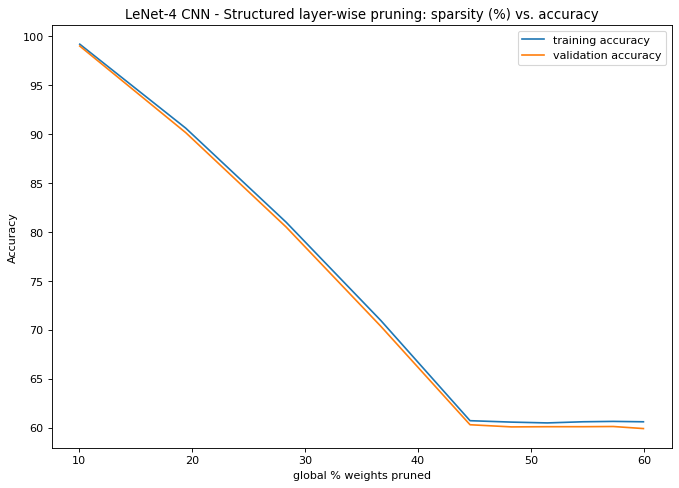

In [88]:
# Visualization of training accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_acc.keys()), list(plot_acc.values()), label = 'training accuracy')
plt.plot(list(plot_val_acc.keys()), list(plot_val_acc.values()), label = 'validation accuracy')

plt.title("LeNet-4 CNN - Structured layer-wise pruning: sparsity (%) vs. accuracy")
plt.xlabel("global % weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

In [92]:
# Python3 dict for training accuracy-
plot_loss = {}

In [93]:
for epoch in history.keys():
    sparsity = history[epoch]['sparsity'].item()
    plot_loss[sparsity] = history[epoch]['best_loss']

In [96]:
# Python3 dict for training accuracy-
plot_val_loss = {}

In [97]:
for epoch in history.keys():
    sparsity = history[epoch]['sparsity'].item()
    plot_val_loss[sparsity] = history[epoch]['best_val_loss']

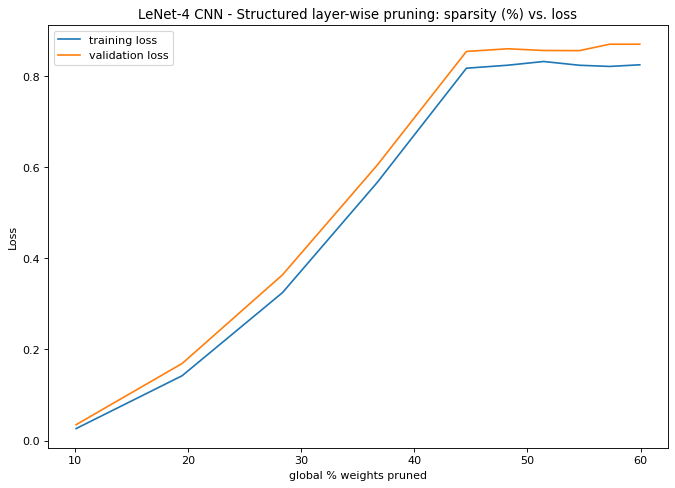

In [99]:
# Visualization of training accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_loss.keys()), list(plot_loss.values()), label = 'training loss')
plt.plot(list(plot_val_loss.keys()), list(plot_val_loss.values()), label = 'validation loss')

plt.title("LeNet-4 CNN - Structured layer-wise pruning: sparsity (%) vs. loss")
plt.xlabel("global % weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [105]:
# Print training details for sparsity vs. accuracies-
for epoch in history.keys():
    print(f"sparsity = {history[epoch]['sparsity'].item():.2f}%, best acc = {history[epoch]['best_acc']:.2f}% & best val acc = {history[epoch]['best_val_acc'].item():.2f}%")

sparsity = 10.09%, best acc = 99.18% & best val acc = 98.99%
sparsity = 19.46%, best acc = 90.60% & best val acc = 90.14%
sparsity = 28.34%, best acc = 80.99% & best val acc = 80.50%
sparsity = 36.72%, best acc = 70.94% & best val acc = 70.35%
sparsity = 44.60%, best acc = 60.71% & best val acc = 60.30%
sparsity = 48.26%, best acc = 60.57% & best val acc = 60.08%
sparsity = 51.43%, best acc = 60.49% & best val acc = 60.10%
sparsity = 54.59%, best acc = 60.60% & best val acc = 60.10%
sparsity = 57.26%, best acc = 60.64% & best val acc = 60.12%
sparsity = 59.93%, best acc = 60.60% & best val acc = 59.91%


### Load pruned model for _Neural Architecture Search_:

https://discuss.pytorch.org/t/proper-way-to-load-a-pruned-network/77694/3


In [106]:
# Initialize and load 'best' pruned weights-
pruned_model = LeNet5().to(device = device)
pruned_model.load_state_dict(torch.load("/home/arjun/Documents/Programs/Python_Codes/PyTorch_Resources/Good_Codes/Pruning_codes_and_resources/LeNet-4_files/LeNet-4_Trained_sparsity-10.09.pth"))

RuntimeError: Error(s) in loading state_dict for LeNet5:
	Missing key(s) in state_dict: "conv1.weight", "conv2.weight", "conv3.weight", "op.weight". 
	Unexpected key(s) in state_dict: "conv1.weight_orig", "conv1.weight_mask", "conv2.weight_orig", "conv2.weight_mask", "conv3.weight_orig", "conv3.weight_mask", "op.weight_orig", "op.weight_mask". 

In [43]:
# Define loss and optimizer-
loss = nn.CrossEntropyLoss()    # applies softmax for us
optimizer = torch.optim.Adam(best_model.parameters(), lr = learning_rate)

In [44]:
print(f"number of non-zero parameter in unpruned LeNet-4 CNN = {count_params(best_model)}")

number of non-zero parameter in unpruned LeNet-4 CNN = 29150


In [45]:
# Compute 'best weights' metrics on validation dataset-
running_loss_val, correct, total = test_model(best_model, test_loader)

# Compute validation loss and accuracy-
val_loss = running_loss_val / len(test_dataset)
val_acc = 100 * (correct / total)

print("Best trained LeNet-4 metrics on validation dataset:")
print(f"val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

Best trained LeNet-4 metrics on validation dataset:
val_loss = 0.0304 & val_acc = 99.14%


### Remove pruning re-parametrization:

Remove the pruning before saving the model by using ```prune.remove(layername, "weight")```. This makes pruning permanent.

In [33]:
prune.remove(best_model.conv1, 'weight')
prune.remove(best_model.conv2, 'weight')
prune.remove(best_model.conv3, 'weight')
prune.remove(best_model.op, 'weight')

Linear(in_features=1080, out_features=10, bias=True)

In [36]:
# list(best_model.conv1.named_parameters())

In [47]:
for layer_name in best_model.state_dict().keys():
    if 'bias' in layer_name:
        continue
    else:
        loc_sparsity = (torch.sum(best_model.state_dict()[layer_name] == 0) / best_model.state_dict()[layer_name].nelement()) * 100
        # print(f"layer = {layer_name} has {best_model.state_dict()[layer_name].shape}")
        print(f"layer = {layer_name} has {loc_sparsity:.2f}% sparsity")

layer = conv1.weight has 75.93% sparsity
layer = conv2.weight has 90.39% sparsity
layer = conv3.weight has 94.13% sparsity
layer = op.weight has 92.25% sparsity


In [49]:
for layer_name, param in best_model.named_parameters():
    print(f"layer: {layer_name} has shape: {param.shape}")

layer: conv1.bias has shape: torch.Size([6])
layer: conv1.weight has shape: torch.Size([6, 1, 3, 3])
layer: conv2.bias has shape: torch.Size([16])
layer: conv2.weight has shape: torch.Size([16, 6, 3, 3])
layer: conv3.bias has shape: torch.Size([120])
layer: conv3.weight has shape: torch.Size([120, 16, 3, 3])
layer: op.bias has shape: torch.Size([10])
layer: op.weight has shape: torch.Size([10, 1080])
